# Forecast Police Service Calls

***

## Libraries

In [50]:
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import boto3
import sagemaker
from sagemaker import get_execution_role
!pip install --disable-pip-version-check -q PyAthena==2.1.0
from pyathena import connect
import plotly.express as px
!pip install --disable-pip-version-check -q seaborn==0.11.0
import seaborn as sns
import datetime

np.random.seed(1)

In [21]:
sns.__version__

'0.10.0'

## Variables - Setup

In [22]:
prefix = "Forecasting/Calls"

db_name = "sdpd"
Bucket = 'sdpd-bucket' 
region = boto3.Session().region_name
s3_staging_dir = "s3://{}/athena/staging".format(Bucket)

sagemaker_session = sagemaker.Session()
role = get_execution_role()
bucket = sagemaker_session.default_bucket()
image_uri = sagemaker.image_uris.retrieve("forecasting-deepar", boto3.Session().region_name)
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)


In [23]:
s3_data_path = f"{bucket}/{prefix}/data"
s3_output_path = f"{bucket}/{prefix}/output"

In [24]:

context_length = 72

## Retrive Data

In [25]:
Stops_Hourly = """SELECT * FROM {}.{}
    order by date_time desc
     LIMIT 1000
     """.format(
    db_name, 'calls_hour'
)

print(Stops_Hourly)

SELECT * FROM sdpd.calls_hour
    order by date_time desc
     LIMIT 1000
     


In [53]:
calls = pd.read_sql(Stops_Hourly, conn)
calls['count'] = calls['count'].astype(int)
calls = calls.sort_values(by='date_time', ascending=True)
#calls['date_time'] = calls['date_time'].isoformat()
calls.head(5)

,date_time,count,year,hour
999,2023-02-11 08:00:00+00:00,1,2023,8
998,2023-02-11 09:00:00+00:00,4,2023,9
997,2023-02-11 10:00:00+00:00,0,2023,10
996,2023-02-11 11:00:00+00:00,3,2023,11
995,2023-02-11 12:00:00+00:00,2,2023,12


In [27]:
call_data= calls['count'].values

In [28]:
last_row = calls.iloc[-1:]
first_date = last_row['date_time']
first_date =pd.to_datetime(first_date)
first_timestamp = first_date.iloc[0].to_pydatetime()
data_length = calls.shape[0]

In [29]:
data_length = data_length
freq='H'

In [55]:
time_series_calls =[]
index = pd.date_range(start="2023-05-05 00:00:00", freq=freq, periods=data_length)
time_series_calls.append(pd.Series(data=call_data , index=index))

In [56]:
time_series_calls

[2023-05-05 00:00:00     1
 2023-05-05 01:00:00     4
 2023-05-05 02:00:00     0
 2023-05-05 03:00:00     3
 2023-05-05 04:00:00     2
                        ..
 2023-06-15 11:00:00    46
 2023-06-15 12:00:00    62
 2023-06-15 13:00:00    44
 2023-06-15 14:00:00    60
 2023-06-15 15:00:00    20
 Freq: H, Length: 1000, dtype: int64]

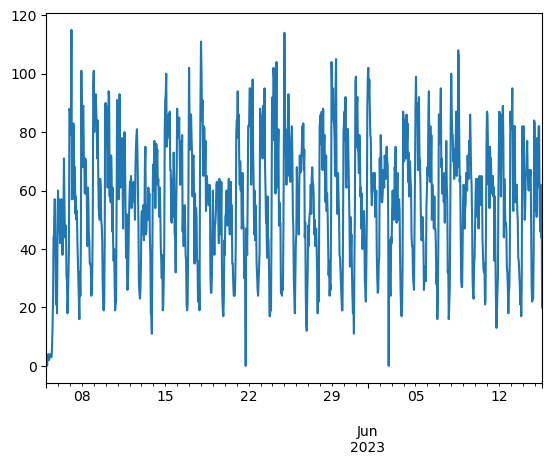

In [57]:
time_series_calls[0].plot()
plt.show()

In [58]:
prediction_length = 48
time_series_training = []
for ts in time_series_calls:
    time_series_training.append(ts[:-prediction_length])

In [59]:
time_series_training

[2023-05-05 00:00:00     1
 2023-05-05 01:00:00     4
 2023-05-05 02:00:00     0
 2023-05-05 03:00:00     3
 2023-05-05 04:00:00     2
                        ..
 2023-06-13 11:00:00    56
 2023-06-13 12:00:00    62
 2023-06-13 13:00:00    53
 2023-06-13 14:00:00    50
 2023-06-13 15:00:00    37
 Freq: H, Length: 952, dtype: int64]

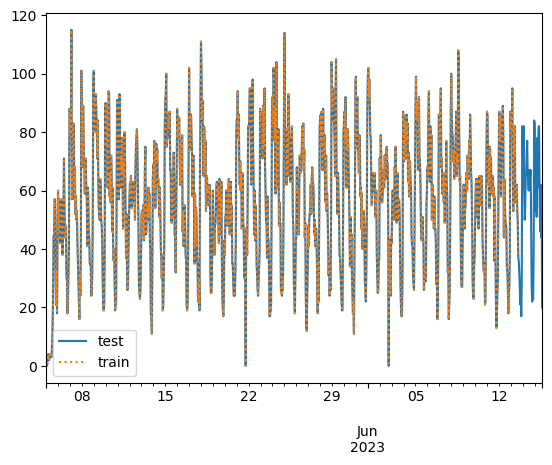

In [60]:
time_series_calls[0].plot(label="test")
time_series_training[0].plot(label="train", ls=":")
plt.legend()
plt.show()

In [61]:
def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat is not None:
        obj["cat"] = cat
    return obj


def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

In [62]:
encoding = "utf-8"
FILE_TRAIN = "train.json"
FILE_TEST = "test.json"
with open(FILE_TRAIN, "wb") as f:
    for ts in time_series_training:
        f.write(series_to_jsonline(ts).encode(encoding))
        f.write("\n".encode(encoding))

with open(FILE_TEST, "wb") as f:
    for ts in time_series_calls:
        f.write(series_to_jsonline(ts).encode(encoding))
        f.write("\n".encode(encoding))
s3 = boto3.client("s3")
s3.upload_file(FILE_TRAIN, bucket, prefix + "/data/train/" + FILE_TRAIN)
s3.upload_file(FILE_TEST, bucket, prefix + "/data/test/" + FILE_TRAIN)

In [63]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_uri=image_uri,
    role=role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    base_job_name="SDPD-Calls",
    output_path=f"s3://{s3_output_path}",
)

In [64]:
hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "gaussian",
    "epochs": "20",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10",
}

In [65]:
estimator.set_hyperparameters(**hyperparameters)

In [66]:
data_channels = {"train": f"s3://{s3_data_path}/train/", "test": f"s3://{s3_data_path}/test/"}

estimator.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: SDPD-Calls-2023-03-29-05-25-05-837


2023-03-29 05:25:09 Starting - Starting the training job...
2023-03-29 05:25:24 Starting - Preparing the instances for training......
2023-03-29 05:26:30 Downloading - Downloading input data...
2023-03-29 05:26:55 Training - Downloading the training image...
2023-03-29 05:27:40 Training - Training image download completed. Training in progress..Arguments: train
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:78: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/jsonref.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping, MutableMapping, Sequence
[03/29/2023 05:27:50 INFO 139805145495360] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'a

In [67]:
job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type="ml.m4.xlarge",
    image_uri=image_uri,
    role=role,
)

INFO:sagemaker:Creating model with name: SDPD-Calls-2023-03-29-05-25-05-837
INFO:sagemaker:Creating endpoint-config with name SDPD-Calls-2023-03-29-05-25-05-837
INFO:sagemaker:Creating endpoint with name SDPD-Calls-2023-03-29-05-25-05-837


-------!

In [68]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):
    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.

        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points

        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length

    def predict(
        self,
        ts,
        cat=None,
        encoding="utf-8",
        num_samples=100,
        quantiles=["0.1", "0.5", "0.9"],
        content_type="application/json",
    ):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.

        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])

        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-1] + pd.Timedelta(1, unit=self.freq) for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req, initial_args={"ContentType": content_type})
        return self.__decode_response(res, prediction_times, encoding)

    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles"],
            "quantiles": quantiles,
        }
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)

    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.date_range(
                start=prediction_times[k], freq=self.freq, periods=self.prediction_length
            )
            list_of_df.append(
                pd.DataFrame(
                    data=response_data["predictions"][k]["quantiles"], index=prediction_index
                )
            )
        return list_of_df

In [69]:
predictor = DeepARPredictor(endpoint_name=endpoint_name, sagemaker_session=sagemaker_session)
predictor.set_prediction_parameters(freq, prediction_length)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [71]:
list_of_df = predictor.predict(time_series_training[:5], content_type="application/json")
actual_data = time_series_calls[:5]

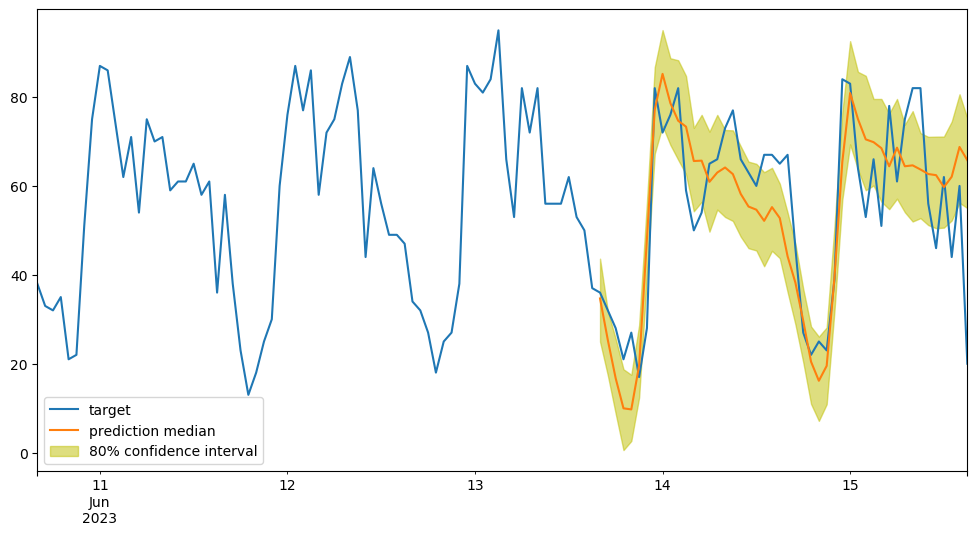

In [72]:
for k in range(len(list_of_df)):
    plt.figure(figsize=(12, 6))
    actual_data[k][-prediction_length - context_length :].plot(label="target")
    p10 = list_of_df[k]["0.1"]
    p90 = list_of_df[k]["0.9"]
    plt.fill_between(p10.index, p10, p90, color="y", alpha=0.5, label="80% confidence interval")
    list_of_df[k]["0.5"].plot(label="prediction median")
    plt.legend()
    plt.show()

In [73]:
sagemaker_session.delete_endpoint(endpoint_name)

INFO:sagemaker:Deleting endpoint with name: SDPD-Calls-2023-03-29-05-25-05-837
